In [9]:
import pandas as pd
import pymorphy2 as pm
import matplotlib.pyplot as plt
import os
import io
import itertools
import operator
import string
import math
import numpy as np
import warnings
from collections import OrderedDict
from gensim.models import KeyedVectors
from IPython.core.display import display, HTML

In [10]:
%matplotlib inline
display(HTML("<style>.container { width:100% !important; }</style>"))
warnings.filterwarnings('ignore')
morph = pm.MorphAnalyzer()
PATH = 'data/songs/'
words_to_remove = [u'куплет', u'припев', u'автор', u'текста', u'текст', u'композитор', u'музыка', u'аутро']
min_words = 40
min_songs = 5

In [ ]:
model = KeyedVectors.load_word2vec_format('/media/anon/9CA43AAEA43A8AB2/word2vec_models/ruwikiruscorpora_upos_cbow_300_20_2017.bin', binary=True)
tone_data = pd.read_csv('data/emo_dict.csv', delimiter=';', encoding='utf-8')
semantics_data = pd.read_csv('data/semantics.csv', delimiter=';', encoding='utf-8')

tone_data = {word: tone for word, tone in zip(tone_data['term'], tone_data['value'])}
semantics_data = {word: entity
                  for word, entity in zip(semantics_data['term'], semantics_data['answerA'])
                  if entity in ['PHYSICAL', 'ABSTRACT']}

In [4]:
def read_file(path):
    try:
        f = io.open(path, 'r', encoding='cp1251')
        return f.read()  # utf-8 expected
    
    except:
        f = io.open(path, 'r')
        return f.read()


def parse_text(string_raw):
    lines = string_raw.split('\n')  # convert string to list
    lines = [i for i in lines if i]  # remove empty lines
    lines = [i.replace('&quot;', '') for i in lines]  # remove &quot;
    lines = [i.replace(u'ё', u'е') for i in lines]  # convert ё to е
    lines_cleared = [''.join([symbol for symbol in word if symbol not in string.punctuation]) for word in lines]  # remove punctuation
    words = [i.split(' ') for i in lines_cleared]  # 2d-list
    words = list(itertools.chain.from_iterable(words))  # flatten 2D list
    words = [word.lower() for word in words if len(word) >= 3 and word.lower() not in words_to_remove]  # remove short words
    return words


def normalize_words(words):
    return [morph.parse(word)[0].normal_form for word in words]

    
def check_in_model(word):
    word = morph.parse(word)[0].normal_form
    if word + '_ADJ' in model:
        return word + '_ADJ'
    if word + '_VERB' in model:
        return word + '_VERB'
    if word + '_NOUN' in model:
        return word + '_NOUN'

    return None

            
def parse_words(words):  # unique
    words = [check_in_model(word) for word in words]
    words = remove_none(words)
    return list(OrderedDict.fromkeys(words))


def parse_combinations(combinations):
    return [i for i in combinations if i[0][-2:] == i[1][-2:]]


def average(lst):
    if len(lst) == 0:
        return None
    return sum(lst) / float(len(lst))


def calc_tfidf(**kwargs):
    word = kwargs['word']
    lyrics = kwargs['lyrics']
    
    tf = float(lyrics.count(word)) / len(lyrics)
    lyrics_with_word = sum([1 for _lyrics in lyricses if word in _lyrics])
    idf = math.log(len(lyricses) / lyrics_with_word, math.e)
    
    return tf * idf


def get_tone(word):
    try:
        return tone_data[word]
    except:
        return None

    
def get_entity(word):
    try:
        return semantics_data[word]
    except:
        return None

def remove_none(lst):
    return [i for i in lst if i]

In [5]:
# PARSE LYRICS

vectors_data = dict()
lyricses = list()
for singer in sorted([i.decode('utf-8') for i in os.listdir(PATH)]):
    vectors_data[singer] = dict()
    for song in sorted(os.listdir(PATH + singer)):
        vectors_data[singer][song] = dict()
        string_raw = read_file(PATH + singer + '/' + song)
        words = parse_text(string_raw)
        
        vectors_data[singer][song]['words_normalized'] = normalize_words(words)
        vectors_data[singer][song]['words_unique'] = parse_words(words)
        
        lyricses.append(vectors_data[singer][song]['words_normalized'])

In [6]:
# REMOVE SMALL SINGERS AND SONGS

for singer in vectors_data.keys():
    for song in vectors_data[singer].keys():
        vectors_data[singer][song]['words_count'] = len(vectors_data[singer][song]['words_unique'])
        if vectors_data[singer][song]['words_count'] < min_words:
            del vectors_data[singer][song]
        
    if len(vectors_data[singer]) < min_songs:
        print '%s has < 5 songs (%s songs), removing' % (singer, len(vectors_data[singer]))
        del vectors_data[singer]

Надежда Бабкина has < 5 songs (1 songs), removing
Чай вдвоем has < 5 songs (3 songs), removing
Ленинград has < 5 songs (3 songs), removing


In [13]:
# CALC SIMILARITIES

for singer in sorted(vectors_data.keys()):
    for song in vectors_data[singer]:
        vectors_data[singer][song]['average_diversity'] = dict()
        
        words_count = 1000  # calc for all words
        combinations = itertools.combinations(vectors_data[singer][song]['words_unique'][:words_count], 2)
        combinations = parse_combinations(combinations)
        _similarities = [model.similarity(i[0], i[1]) for i in combinations]
        vectors_data[singer][song]['average_diversity'][words_count] = -0.5 * average(_similarities) + 0.5
        
        words_count = 40  # calc for only 40 first words
        combinations = itertools.combinations(vectors_data[singer][song]['words_unique'][:words_count], 2)
        combinations = parse_combinations(combinations)
        _similarities = [model.similarity(i[0], i[1]) for i in combinations]
        vectors_data[singer][song]['average_diversity'][words_count] = -0.5 * average(_similarities) + 0.5

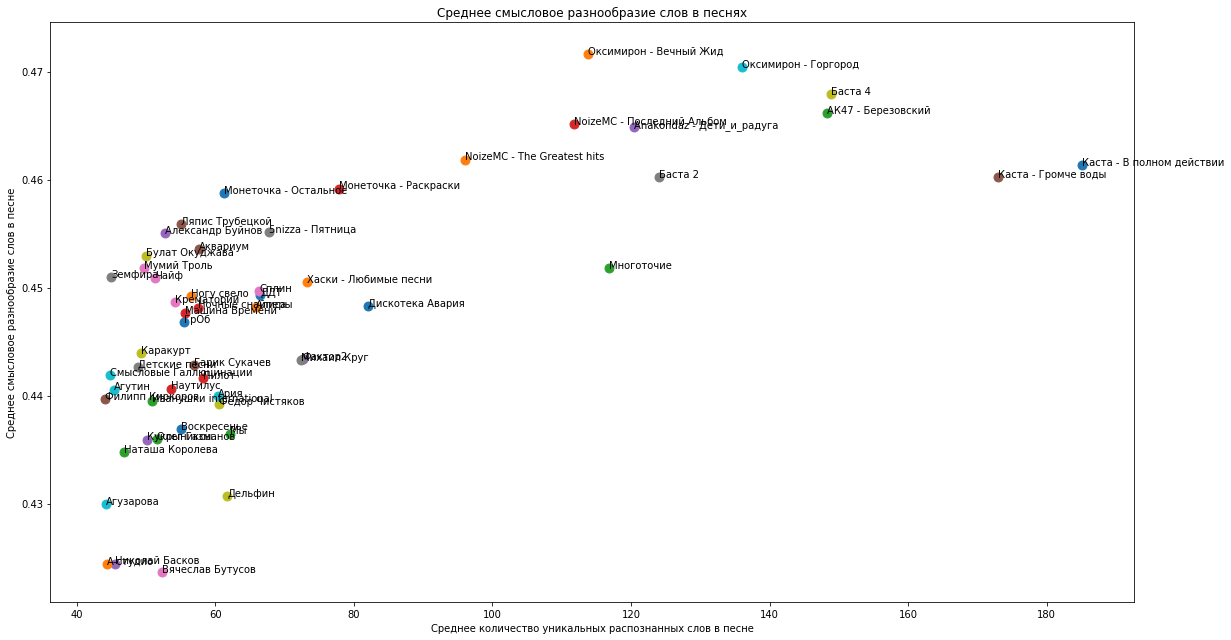

In [14]:
# DRAW SCATTER SIMILARITY

words_count = 1000
fig = plt.figure(figsize=[16, 9])
for singer in vectors_data:
    _words_count = average([song['words_count'] for song in vectors_data[singer].values()])
    _average_diversity = average([song['average_diversity'][words_count]
                                  for song in vectors_data[singer].values()])

    plt.scatter(_words_count, _average_diversity, s=80, label=singer)
    plt.annotate(singer, (_words_count, _average_diversity), size=10)

plt.xlabel(u'Среднее количество уникальных распознанных слов в песне')
plt.ylabel(u'Среднее смысловое разнообразие слов в песне')
plt.title(u'Среднее смысловое разнообразие слов в песнях')
plt.tight_layout()

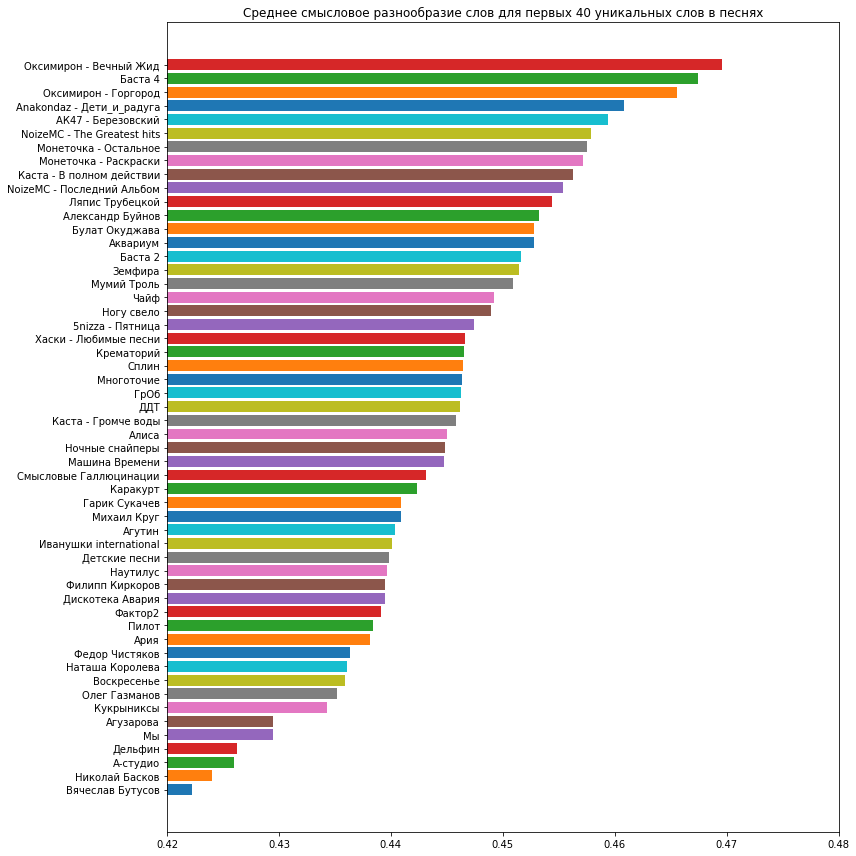

In [15]:
# DRAW BAR SIMILARITY

words_count = 40
fig = plt.figure(figsize=[12, 12])
plot_data = list()
for singer in vectors_data:
    plot_data.append([singer, average([song['average_diversity'][words_count] 
                                       for song in vectors_data[singer].values()])])

plot_data.sort(key=operator.itemgetter(1))

for bar in plot_data:
    plt.barh(bar[0], bar[1])

plt.title(u'Среднее смысловое разнообразие слов для первых %s уникальных слов в песнях' % words_count)
plt.xlim([0.42, 0.48])
plt.tight_layout()

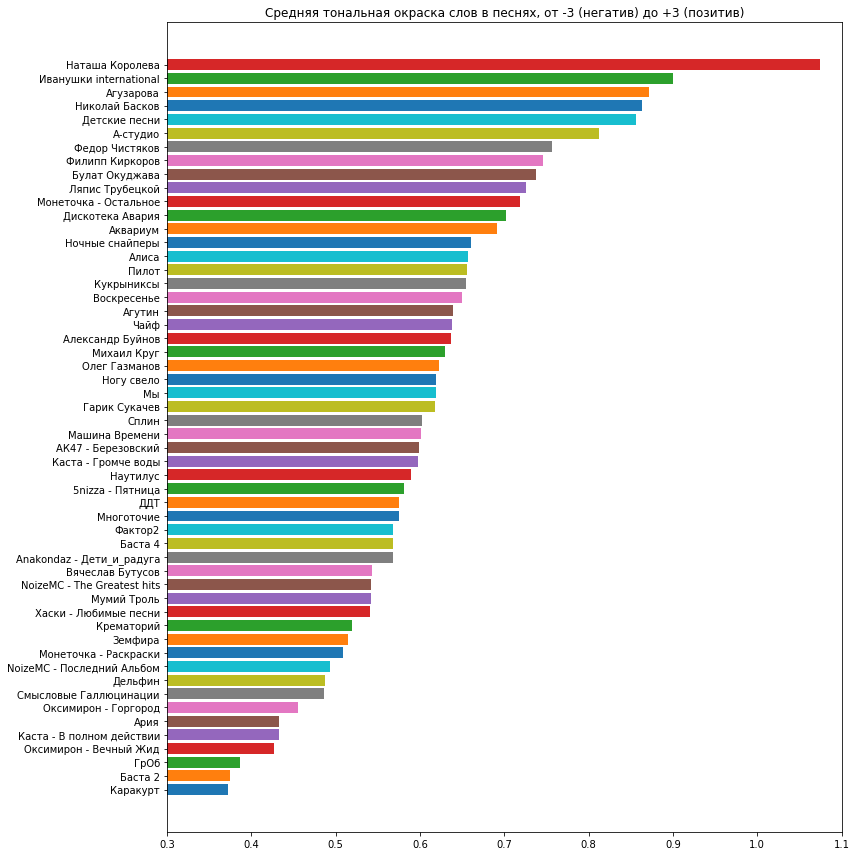

In [16]:
# TONE

for singer in vectors_data:
    for song in vectors_data[singer]:
        vectors_data[singer][song]['tones'] = [get_tone(word) for word in vectors_data[singer][song]['words_normalized']]
        vectors_data[singer][song]['tones'] = remove_none(vectors_data[singer][song]['tones'])
        vectors_data[singer][song]['tone'] = average([i for i in vectors_data[singer][song]['tones']])

fig = plt.figure(figsize=[12, 12])
plot_data = list()
for singer in vectors_data:
    plot_data.append([singer, average([song['tone'] for song in vectors_data[singer].values()])])

plot_data.sort(key=operator.itemgetter(1))

for bar in plot_data:
    plt.barh(bar[0], bar[1])

plt.title(u'Средняя тональная окраска слов в песнях, от -3 (негатив) до +3 (позитив)')
plt.xlim([0.3, 1.1])
plt.tight_layout()

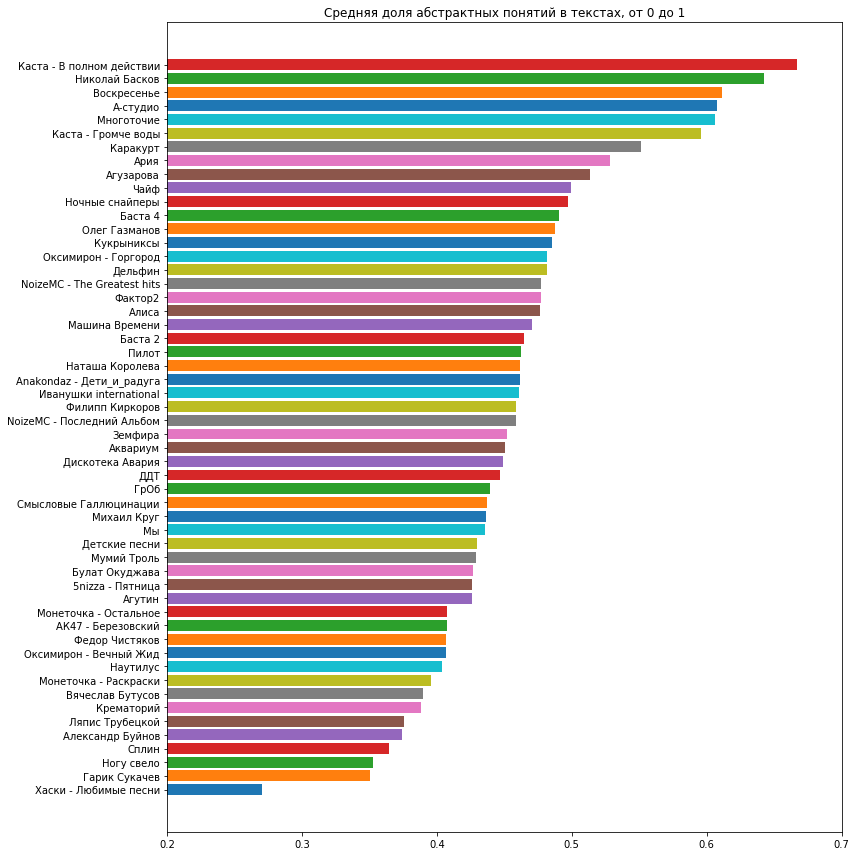

In [17]:
# ABSTRACT

for singer in vectors_data:
    for song in vectors_data[singer]:
        vectors_data[singer][song]['entities'] = [get_entity(word) for word in vectors_data[singer][song]['words_normalized']]
        vectors_data[singer][song]['entities'] = remove_none(vectors_data[singer][song]['entities'])
        vectors_data[singer][song]['abstract_ratio'] = (float(vectors_data[singer][song]['entities'].count('ABSTRACT')) /
                                                        len(vectors_data[singer][song]['entities']))

fig = plt.figure(figsize=[12, 12])
plot_data = list()
for singer in vectors_data:
    plot_data.append([singer, average([song['abstract_ratio'] for song in vectors_data[singer].values()])])

plot_data.sort(key=operator.itemgetter(1))

for bar in plot_data:
    plt.barh(bar[0], bar[1])

plt.title(u'Средняя доля абстрактных понятий в текстах, от 0 до 1')
plt.xlim([0.2, 0.7])
plt.tight_layout()

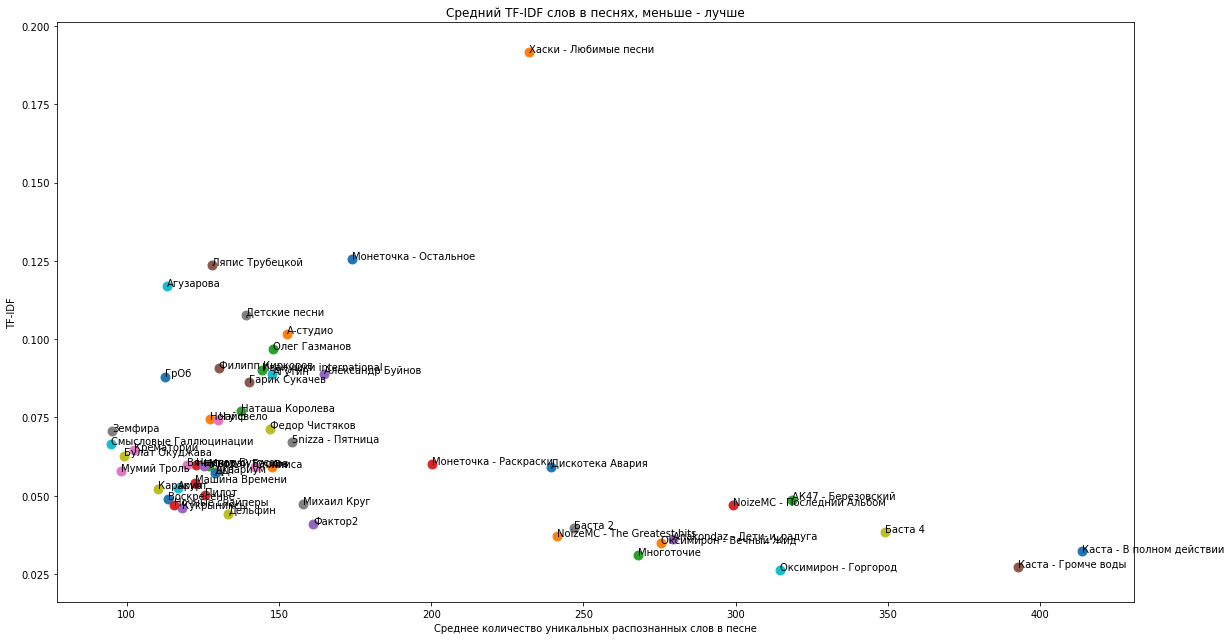

In [18]:
# TF-IDF

for singer in sorted(vectors_data.keys()):
    for song in vectors_data[singer]:
        vectors_data[singer][song]['tfidfs'] = [calc_tfidf(word=word,
                                                           lyrics=vectors_data[singer][song]['words_normalized'])
                                                for word in vectors_data[singer][song]['words_normalized']]

fig = plt.figure(figsize=[16, 9])
for singer in vectors_data:
    average_words_count = average([len(song['words_normalized']) for song in vectors_data[singer].values()])
    average_tfidf = average([average(song['tfidfs']) for song in vectors_data[singer].values()])
    plt.scatter(average_words_count, average_tfidf, s=80, label=singer)
    plt.annotate(singer, (average_words_count, average_tfidf), size=10)

plt.xlabel(u'Среднее количество уникальных распознанных слов в песне')
plt.ylabel(u'TF-IDF')
plt.title(u'Средний TF-IDF слов в песнях, меньше - лучше')
plt.tight_layout()

In [19]:
# CORRELATION BETWEEN DIVERSITY AND TF-IDF

words_count = 1000
diversity_data = list()
tfidf_data = list()
for singer in vectors_data:
    diversity_data.append(average([song['average_diversity'][words_count]
                                   for song in vectors_data[singer].values()]))
    tfidf_data.append(average([average(song['tfidfs'])
                               for song in vectors_data[singer].values()]))
    
np.corrcoef(diversity_data, tfidf_data)[0][1]

-0.28536498525527765